In [2]:
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import torch
from torch.utils.data import random_split,DataLoader
from torch import nn
from PIL import Image
from torch.autograd import Variable

c:\ProgramData\Anaconda3\envs\Capstone_PT_GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#define the resolution that you want.
shape1=64
shape2=72

In [4]:
# scale the spec2D array. i.e. reduce the resolution.
def scale_array(x,new_size):
    min_el = np.min(x)
    max_el = np.max(x)
    y = np.array(Image.fromarray(x).resize(new_size))
    y = y/(max_el-min_el)+min_el
    y[y<np.average(y)/4]=0
    ymax = np.max(y)
    y[y==ymax]=max_el
    return y


In [5]:
winter_ds = xr.open_dataset('F:\\combined-small16x.nc',engine = "netcdf4",decode_times=False)
winter_ds

<xarray.Dataset>
Dimensions:    (time: 1001, freq: 64, dir: 72)
Coordinates:
  * time       (time) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * freq       (freq) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * dir        (dir) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables:
    cott2D     (time, freq, dir) float32 ...
    cott2D05   (time, freq, dir) float32 ...
    rott2Dm1   (time, freq, dir) float32 ...
    rott2Dm15  (time, freq, dir) float32 ...
    cape2Dm25  (time, freq, dir) float32 ...
    cape2Dm3   (time, freq, dir) float32 ...
    cott2Dm05  (time, freq, dir) float32 ...
    cott2Dm1   (time, freq, dir) float32 ...

In [6]:
def calsmv(x): # calculate the number of values that less than one-eighth of the mean value in one matrix.
    s = winter_ds[x].values
    num = 0
    for i in range(len(s)):
        num += len(s[i][s[i]<np.average(s)/8])
    num = num / len(s)
    return num


In [8]:
total = calsmv("rott2Dm1")+calsmv("rott2Dm15")+calsmv("cape2Dm25")+calsmv("cape2Dm3")+calsmv("cott2Dm05")+calsmv("cott2Dm1")+calsmv("cott2D")
avgnum = total/7 # The average number of values that less than one-eighth of the mean value of the matrix(close to zero) in each 64*72(4608) spec2D for the whole dataset.
percent = avgnum /4608 # at least 61% of the values in each spec2D are close to zero.
print(percent)

0.6142953338823873


In [9]:
def reduce_res(inp): # customize the resolution
    l = len(inp)
    out = np.zeros((l,shape1,shape2))
    for i in range(0,l):
        out[i] = scale_array(inp[i],(shape2,shape1))
    return out

### If need to use the raw data, run this chunk.

In [10]:
# # use the original data of the spec2D.
# rott2Dm1=winter_ds["rott2Dm1"].values
# rott2Dm15 = winter_ds["rott2Dm15"].values
# cape2Dm25 = winter_ds["cape2Dm25"].values
# cape2Dm3 = winter_ds["cape2Dm3"].values
# cott2Dm05 = winter_ds["cott2Dm05"].values
# cott2Dm1 = winter_ds["cott2Dm1"].values
# cott2D = winter_ds["cott2D"].values

### If need to replace small values with zero and customize the resolution, run this chunk.

In [12]:
# use the customized resolution of the spec2D and replace the small values with zero.
rott2Dm1 = reduce_res(winter_ds["rott2Dm1"].values)
rott2Dm15 = reduce_res(winter_ds["rott2Dm15"].values)
cape2Dm25 = reduce_res(winter_ds["cape2Dm25"].values)
cape2Dm3 = reduce_res(winter_ds["cape2Dm3"].values)
cott2Dm05 = reduce_res(winter_ds["cott2Dm05"].values)
cott2Dm1 = reduce_res(winter_ds["cott2Dm1"].values)
cott2D = reduce_res(winter_ds["cott2D"].values)

### Split the dataset to train and test

In [13]:
X1 = torch.tensor(rott2Dm1)
X2 = torch.tensor(rott2Dm15)
X3 = torch.tensor(cape2Dm25)
X4 = torch.tensor(cape2Dm3)
X5 = torch.tensor(cott2Dm05)
X6 = torch.tensor(cott2Dm1)
Y1 = torch.tensor(cott2D)
Y1 = Y1.reshape(1001,shape1,shape2).cuda()
X = torch.stack((X1, X2,X3,X4,X5,X6))
X = X.reshape(1001,6,shape1,shape2).cuda()
print(X.shape)
print(Y1.shape)
X = X.requires_grad_()
Y1 = Y1.requires_grad_()
DS = torch.utils.data.TensorDataset(X,Y1)
train_ds, test_ds = random_split(
    dataset=DS,
    lengths=[701, 300],
    generator=torch.Generator().manual_seed(0)
)

torch.Size([1001, 6, 64, 72])
torch.Size([1001, 64, 72])


In [14]:
def printimg(img): # print the spec2D
    plt.imshow(img.cpu().detach().numpy(),interpolation='nearest',cmap='bone',origin='upper')
    plt.colorbar(shrink=0.5)
    plt.xticks(())
    plt.yticks(())
    plt.show()

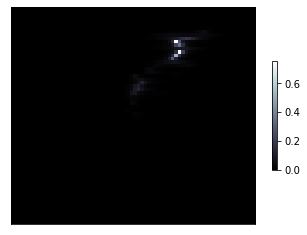

In [15]:
printimg(X[0][0])

## Build the Convlstm model

In [16]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Sequential(nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True))
        self.Whi = nn.Sequential(nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False))
        self.Wxf = nn.Sequential(nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True))
        self.Whf = nn.Sequential(nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False))
        self.Wxc = nn.Sequential(nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True))
        self.Whc = nn.Sequential(nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False))
        self.Wxo = nn.Sequential(nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True))
        self.Who = nn.Sequential(nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False))

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)

        return outputs, (x, new_c)

### start training process

In [13]:

convlstm = ConvLSTM(input_channels=5, hidden_channels=[64,32,32,1], kernel_size=3, step=5,
                        effective_step=[3,4]).cuda()
loss_function = nn.MSELoss()
#optimizer = torch.optim.SGD(convlstm.parameters(),lr=0.001)
#optimizer = torch.optim.RMSprop(convlstm.parameters(),lr=0.001)
optimizer = torch.optim.Adam(convlstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
convlstm.train()
for epoch in range(100):
    loader = DataLoader(train_ds, batch_size=8,shuffle = True)
    convlstm.train()
    for step,(batch_x,batch_y) in enumerate(loader):
        print(step)
        batch_x=batch_x.float()
        print(type(batch_x))
        y_pred = convlstm(Variable(batch_x))[0][0].reshape(convlstm(Variable(batch_x))[0][0].shape[0],shape1,shape2)
        print(y_pred.shape)
        loss = torch.sqrt(loss_function(y_pred,batch_y.float()))
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(convlstm,'C:/Users/asus/Desktop/CITS5553/conlstm2')

0
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0504, device='cuda:0', grad_fn=<SqrtBackward0>)
1
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0522, device='cuda:0', grad_fn=<SqrtBackward0>)
2
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0572, device='cuda:0', grad_fn=<SqrtBackward0>)
3
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0490, device='cuda:0', grad_fn=<SqrtBackward0>)
4
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0623, device='cuda:0', grad_fn=<SqrtBackward0>)
5
<class 'torch.Tensor'>
torch.Size([8, 64, 72])
tensor(0.0452, device='cuda:0', grad_fn=<SqrtBackward0>)


KeyboardInterrupt: 

#### clear the memory if error of 'cuda out of memory' appears. Run this chunk and restart the kernel.

In [15]:
# # clear the memory
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache() 

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 15% | 98% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 14% |  7% |


#### load the trained model

In [17]:
convlstm = torch.load('C:/Users/asus/Desktop/CITS5553/conlstmnew')

### predict the test set

In [18]:
predictlst=[]
truthlst=[]
loslst=[]
loss_function = nn.MSELoss()
testds = DataLoader(test_ds, batch_size=8,shuffle = True)
running_loss = 0.
convlstm.eval()
for step,(batch_tx,batch_ty) in enumerate(testds):
    batch_tx=batch_tx.float()
    yt_pred = convlstm(Variable(batch_tx))[0][0].reshape(convlstm(Variable(batch_tx))[0][0].shape[0],shape1,shape2)
    print(yt_pred.shape)
    for i in range(convlstm(Variable(batch_tx))[0][0].shape[0]):
        #printimg(yt_pred[i].reshape(shape1,shape2).detach())
        predictlst.append(yt_pred[i].reshape(shape1,shape2))
        #print(yt_pred[i])
        #printimg(batch_ty[i].reshape(shape1,shape2).detach())
        truthlst.append(batch_ty[i])
        print(torch.sqrt(loss_function(yt_pred[i], batch_ty[i].float())))
        loslst.append(torch.sqrt(loss_function(yt_pred[i], batch_ty[i].float())))
    loss = torch.sqrt(loss_function(yt_pred, batch_ty.float()))
    running_loss += (loss.item() - running_loss) / (step + 1)

print("Test loss: {};".format(running_loss))

torch.Size([8, 64, 72])
tensor(0.0543, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0385, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0303, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0588, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0618, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([8, 64, 72])
tensor(0.0293, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0475, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0466, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0301, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0473, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0339, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0529, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([8, 64, 72])
tensor(0.0525, d

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 4.96 GiB already allocated; 0 bytes free; 5.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### print random three spec2Ds of prediction and truth.

20
prediction


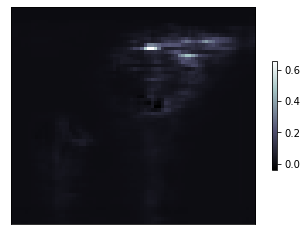

truth


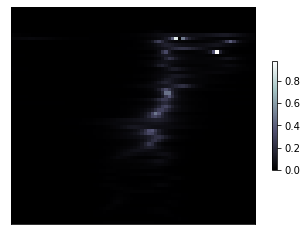

loss is: tensor(0.0473, device='cuda:0', grad_fn=<SqrtBackward0>)
40
prediction


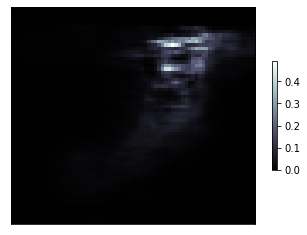

truth


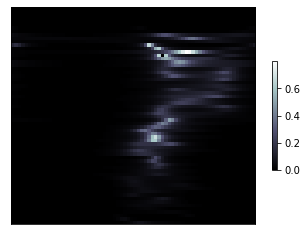

loss is: tensor(0.0634, device='cuda:0', grad_fn=<SqrtBackward0>)
4
prediction


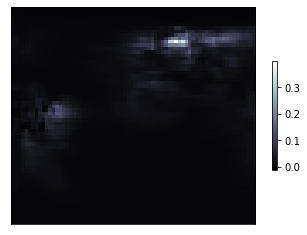

truth


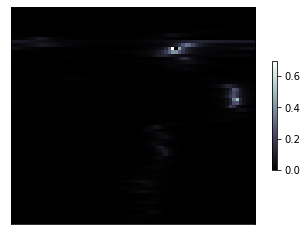

loss is: tensor(0.0303, device='cuda:0', grad_fn=<SqrtBackward0>)


In [19]:
import random
rl = random.sample(range(1,50),3)
for i in rl:
    print(i)
    print('prediction')
    printimg(predictlst[i])
    print('truth')
    printimg(truthlst[i])
    print('loss'+' is: '+str(loslst[i]))
